In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import interp1d, interp2d
import sofi
import sofiism as si
from time import time
from scipy import signal
import pandas as pd
from gaussfitter_as import gaussfit
import cv2
import gaussfitter as gs
from scipy.optimize import curve_fit
import joblib
import control as ctr
import time

In [2]:

## Change trigger ID in later function
def upload_file(data_folder, filename):
    """
    upload SPAD binary file and retrieve timestamps and addreses of each tag in two separate tables 
    """
    global a
    fh =np.fromfile(data_folder+filename,dtype =np.uint8)
    fh1= np.array(fh.reshape(-1,4))
    print(fh1[:8,:])
    fh2 = np.array(np.fliplr(fh1))
    fh3 = np.unpackbits(fh2[1:-1,:]).reshape(-1,32)

    addr = np.array(np.fliplr(fh3[:,0:6]))
    timestamp = np.array(np.fliplr(fh3[:,6:]))
    val_addr = np.packbits(addr,axis=1,bitorder='little')-32
    val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
    val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                    2**24*val_timestamp[:,3]
    return(val_addr,val_timestamps)
def detector_intensity(val_addr):
    """
    Check intensity of each detector and triggers(position 23 and 24 in return table)
    """
    
    return(np.unique(val_addr, return_counts=True)[1])


def time_unwrap(val_timestamps):
    """
    Unwrap timestamps into one nondecresing series 
    """
    a=val_timestamps.shape[0]
    val_time =val_timestamps.astype('int64')
    for i in range(a-1):
        if val_time[i+1]-val_time[i]<-1*2**25:
            val_time[i+1:]+=2**26

    return(val_time)
def histogram_creation(val_addr,val_time,time_range):
    """
    Creates g2 correlation histogram
    middle row(position time_range)-tags in the same time
    time_range-maximum registered tag difference
    
    """
    a=val_time.shape[0]
    hist = np.zeros((23,23,2*time_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=time_range and diff>=0:
            if val_addr[i]<25 and val_addr[i+b]<25:
                hist[val_addr[i],val_addr[i+b],time_range+diff]+=1
                hist[val_addr[i+b],val_addr[i],time_range-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break
    return(hist)
def calc_correction(mode='create', channels=23,hist=[],counts_detec=[],filename=''):
    """
    mode create - calculate correction parameters and save it in pkl file
    mode upload - upload correction parameters from pkl file
    """
    if mode =='create':
        correction = np. zeros((channels,channels))
        correction_extra  = np. zeros((18,3))
        for i in range(channels):
            for j in range(channels):
                if i!=j:
                    correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
                if i+5==j:

                    correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
        joblib.dump((correction,correction_extra),filename)
        return(correction,correction_extra)
    elif mode == 'upload':
        (correction,correction_extra) =joblib.load(filename)
        return(correction,correction_extra)
def histogram_correction(hist,correction,correction_extra,counts_detec,middle_row):
    """
    Correct histograms using near 0 delay correction parameters
    
    """
    hist_corrected = np.copy(hist)
    for i in range(23):
        for j in range(23):
            if i!=j:
                hist_corrected[i,j,middle_row] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
            if i+5==j:
                hist_corrected[i,j,middle_row+1] -=(counts_detec[i])*correction_extra[i,0]
                hist_corrected[j,i,middle_row-1] -=(counts_detec[i])*correction_extra[i,0]            
                hist_corrected[i,j,middle_row+2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[j,i,middle_row-2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[i,j,middle_row+3] -=(counts_detec[i])*correction_extra[i,2]
                hist_corrected[j,i,middle_row-3] -=(counts_detec[i])*correction_extra[i,2]
    return(hist_corrected)

def scan_points(val_addr,x_points,y_points):
    """
    finding triggers inside tags list and return list of all tags as numpy array
    ok
    """

    a = len(val_addr)
    pixels = np.zeros((y_points,x_points))
    lines = np.where(val_addr==234)[0]

    if lines.shape ==(0,):
        lines = np.array([0,a])
    else:
        lines =np.concatenate((lines,[a]))
    for i in range(y_points):
        part = val_addr[lines[i]:lines[i+1]]
        pix = np.concatenate(([0],np.where(part==233)[0],[lines[i+1]-lines[i]]))
        print(pix)
        if i%2==0:
            pixels[i] = lines[i] + pix[:-1]
        else:
            pixels[i] = lines[i] + np.flip(pix[:-1])
    return(pixels,lines)


def counts_scan(val_addr,val_timestamps,pixels,dwell_time):
    """
    return number of counts of every detector/every pixel in desired dwell time
    dwell time in miliseconds
    """
    dwell_time = int(dwell_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        counts[i,j,val_addr[int(pixels[i,j]+delta)]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        counts[i,y-1-j,val_addr[int(pixels[i,y-1-j]+delta)]] += 1
                    delta += 1

    return(counts)

def counts_scan_binned(val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    dwell_time = int(dwell_time * 1e5)
    bin_time = int(bin_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((int(np.ceil(dwell_time/bin_time)),x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            delta= 0
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,j])+delta]- val_timestamps[int(pixels[i,j])])/bin_time))
                        counts[bin_number,i,j,val_addr[int(pixels[i,j])+delta]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,y-1-j])+delta]- val_timestamps[int(pixels[i,y-1-j])])/bin_time))
                        counts[bin_number,i,y-1-j,val_addr[int(pixels[i,y-1-j])+delta]] += 1
                    delta += 1
    return(counts)


def counts_scan_binned_add(counts,val_addr,val_timestamps,pixels,dwell_time,bin_time,x,y):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    Add result to existing counts table
    """

    counts1 = np.zeros(1,(np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                counts1[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                delta += 1
    counts = np.concatenate((counts,counts),axis = 0)
    return(counts)        
        
def histogram_plot(val_addr):
    """
    Create a detector heat map for certain range of tags
    """
    pos = np.zeros((val_addr.shape[0],2))
    for i in range(val_addr.shape[0]):
        if i%1e6==0:
            print(i)
        temp=val_addr[i]
        if temp<25:
            if temp<=4:
                pos[i,0]=np.sqrt(3)
                pos[i,1] = temp-2.
            elif temp<=8:
                pos[i,0]=np.sqrt(3)/2.
                pos[i,1] = temp-6.5            
            elif temp<=13:
                pos[i,0]=0
                pos[i,1] = temp-11. 
            elif temp<=17:
                pos[i,0]=-np.sqrt(3)/2.
                pos[i,1] = temp-15.5  
            elif temp<=23:
                pos[i,0]=-np.sqrt(3)
                pos[i,1] = temp-20.
    plt.hexbin(pos[:,1],pos[:,0],gridsize=(4,2))
    plt.colorbar()
    plt.show()
    return(pos)

def counts_binned(val_addr,val_timestamps,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    bin_time = int(bin_time * 1e5)
    max_time = max(val_timestamps)
    counts = np.zeros((int(np.ceil(max_time/bin_time)),23))

    for i  in range(len(val_addr)):
        if val_addr[i]<25:
            bin_number = int(np.floor((val_timestamps[i])/bin_time))
            counts[bin_number,val_addr[i]] += 1
           
    return(counts)


(correction,correction_extra)= joblib.load('correction_parameters_laser.pkl')
vx=np.load('vx_06_07_2020.npy')
vy=np.load('vy_06_07_2020.npy')


In [76]:
#intensity scan analysis with time binning
#final data- (counts) intensity value of each pixel in every scan point binned 
# format :(x,y,detector)
# dwell and bin times in ms
nanoSPAD_X= 30
nanoSPAD_Y= 30
dwell_time = 200
bin_time = 0.1
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.09/",filename = "AF647+glicerol_02092020_350nw_80Mhz_v6")
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)

#Counts variables(with/without binning)
#counts = counts_scan(val_addr,val_time,points,dwell_time = dwell_time)
s = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)

[[255 255 255 239]
 [ 84  74   0 168]
 [190 102   0 128]
 [208 121   0 128]
 [ 46 142   0 128]
 [148 181   0 128]
 [122 195   0 128]
 [164 200   0 128]]
[     0   4477   8620  12819  17145  21322  25825  30080  34368  38614
  42862  47235  51540  55644  59927  64266  68595  72915  77036  81240
  85464  89660  93857  98039 102015 106107 110202 114248 118143 122078
 126022 129978]
[     0   3829   7783  11807  15758  19733  23683  27867  31861  36074
  40109  44381  48503  52703  57069  61141  65417  69697  73895  78202
  82312  86642  90841  95238  99666 104040 108445 112804 116967 121264
 125432 129708]
[     0   4252   8565  12777  17000  21291  25698  30058  34381  38618
  43004  47340  51730  55862  60201  64448  68801  73134  77324  81541
  85712  89930  94090  98166 102176 106160 110063 114081 118041 121932
 125973 129858]
[     0   3824   7758  11679  15656  19584  23687  27702  31869  36128
  40370  44433  48734  53020  57316  61772  66061  70343  74734  79138
  83383  87717  92

In [34]:
val_addr = val_addr[1000000:]
val_timestamps = val_timestamps[1000000:]
nanoSPAD_Y= 29
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)

#Counts variables(with/without binning)
counts = counts_scan(val_addr,val_time,points,dwell_time = dwell_time)
s = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)

[      0   61260  116497  166045  212274  255987  298351  340756  381543
  421404  460469  498237  536379  573318  609356  644046  678452  712502
  746036  780348  814935  849831  887158  926329  966817 1009336 1051350
 1095102 1140057 1188265 1239627 1292569]
[     0  49891  93157 132665 169647 204697 237431 268992 299133 327759
 353924 379574 404752 428500 452131 475050 497563 520118 542592 564780
 586886 609147 631671 653901 676219 698834 722102 746982 773806 802160
 832760 865885]
[     0  31082  58231  84012 107270 128842 149483 169280 188780 207972
 226533 244527 262148 280404 298593 315953 333947 351922 369818 388473
 407012 425719 445204 465319 486909 508231 530860 554498 578949 604062
 631390 661670]
[     0  28949  54272  77563 100397 121643 142022 160882 178730 195855
 212930 229990 246242 262062 277995 293550 309215 323708 338279 353005
 367978 383341 399723 416474 433414 449079 465430 482909 500559 520283
 540651 562612]
[     0  20884  41158  59341  75590  91893 107534 12

KeyboardInterrupt: 

In [15]:
data=np.loadtxt('200uW_80MHz_AF647+glicerol_v2.asc')

In [16]:
256000/256

1000.0

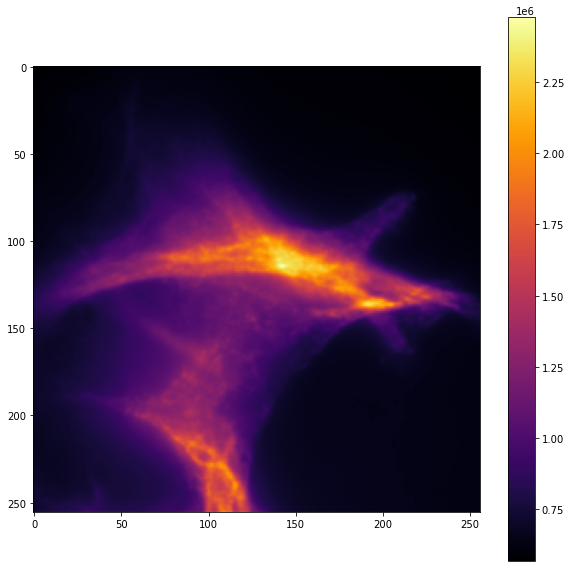

In [21]:
data=data.reshape((1000,256,257))
plt.figure(figsize=(10,10))
plt.imshow((data.sum(axis=0)[:,1:]))
plt.colorbar()

In [18]:
ac2=sofi.autocumulant_2(data,1)

In [13]:
np.shape((ac2))

(256, 257)

In [28]:
ac2=np.zeros((256,256))
for i in range(1,10):
    ac2+=np.array(sofi.autocumulant_2(data,i))[:,1:]

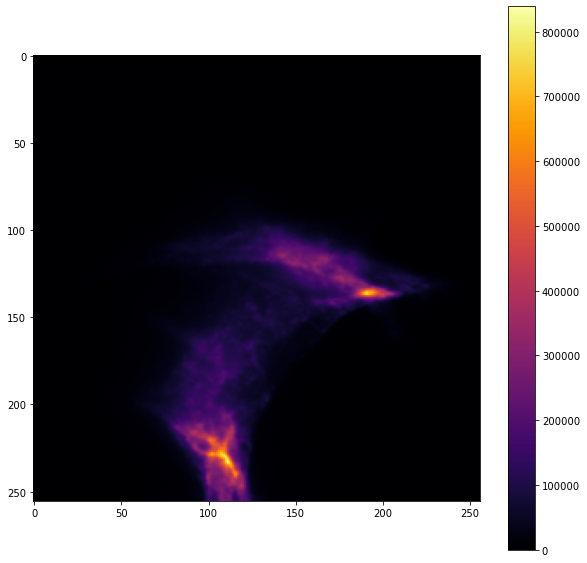

In [20]:
plt.figure(figsize=(10,10))
plt.imshow((np.abs(ac2)[:,1:]),vmin=0)
plt.colorbar()
plt.show()

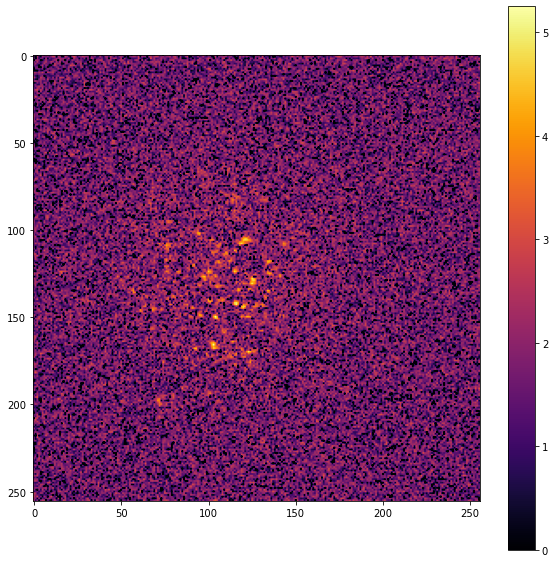

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(ac2)[:,1:]),vmin=0)
plt.colorbar()
plt.show()

In [ ]:
s=np.load('single_atto_647_18_8_AM_v6_5mhz_800nW_scan.npy')

In [40]:
s.shape

(2800, 30, 31, 23)

In [77]:
scans=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],s.shape[3]+1))
scans[0,:,:,:,:-2]=np.concatenate((s[:,:,:,:14],s[:,:,:,15:]),axis=3)

In [78]:
scans.shape

(1, 2000, 30, 31, 24)

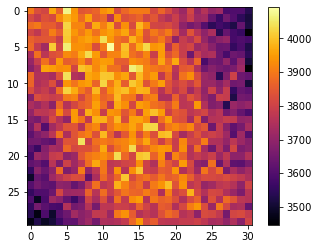

In [79]:
plt.imshow(scans.sum(axis=(0,1,4)))
plt.colorbar()

In [73]:
xc2=si.get_xc2(scans[0,:,:,:,1:],0.5*vx[1:],0.5*vy[1:],1)
for i in range(2,10):
    xc2+=si.get_xc2(scans[0,:,:,:,1:],0.5*vx[1:],0.5*vy[1:],i)

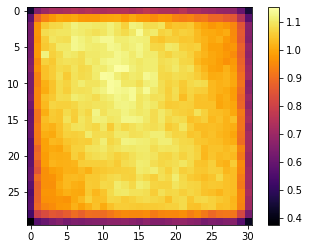

In [80]:
plt.imshow(si.ac1_image(scans[:,:,:,:,1:],0.5*vy[1:],0.5*vx[1:]))
plt.colorbar()

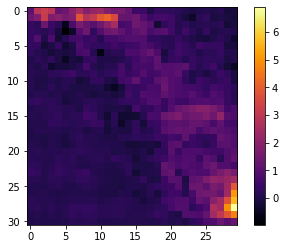

In [74]:
plt.imshow(xc2.T)
plt.colorbar()

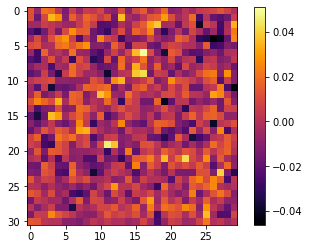

In [81]:
plt.imshow(si.get_xc2(si.rebin(scans,1)[0,:,:,:,1:],0.5*vx[1:],0.5*vy[1:],1).T)
plt.colorbar()

In [52]:
xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1)
xc20=si.get_xc2(scans[0,:,:,:,:],vx,vy,0)

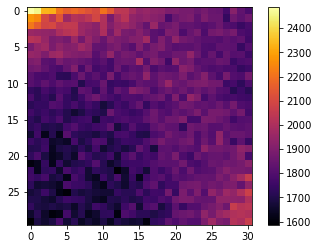

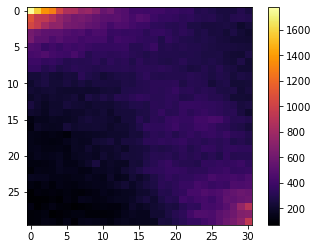

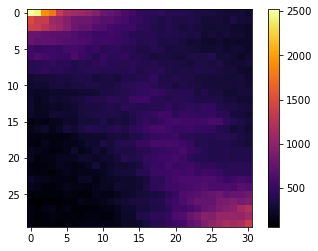

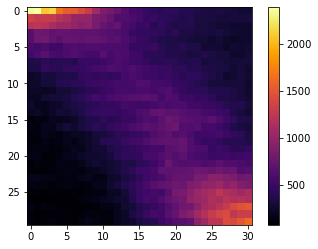

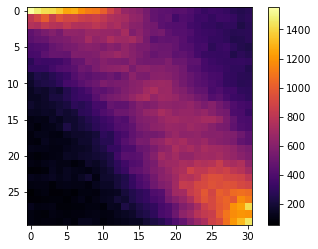

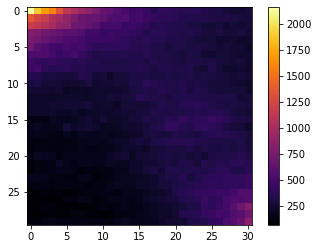

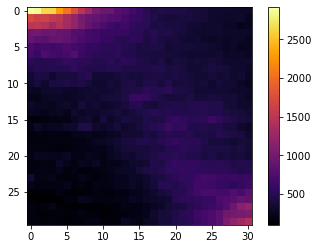

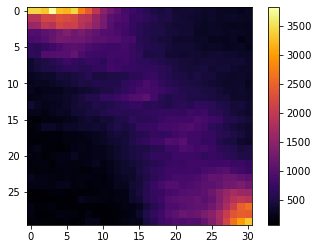

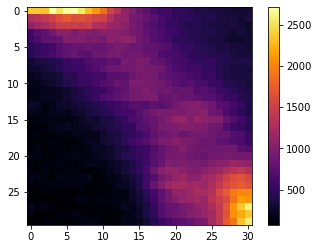

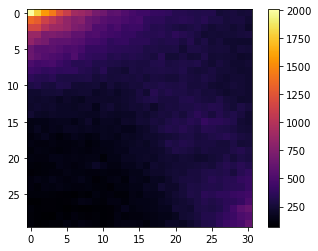

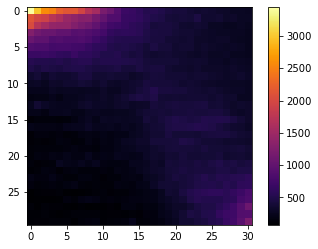

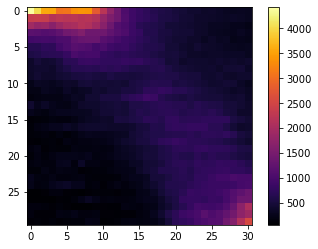

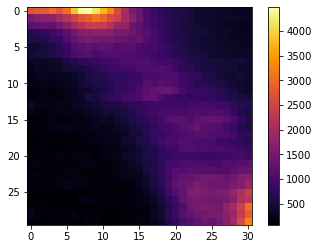

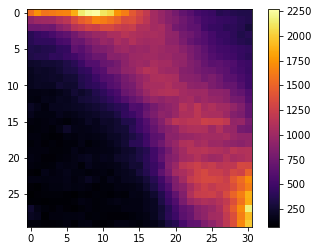

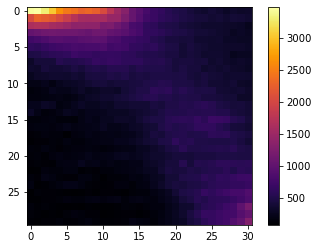

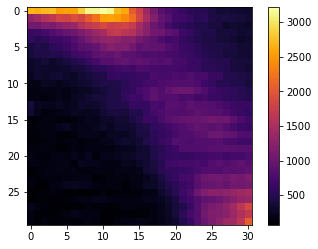

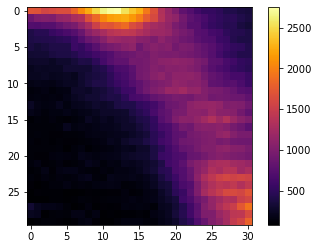

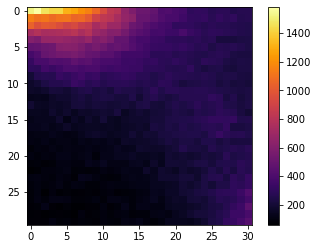

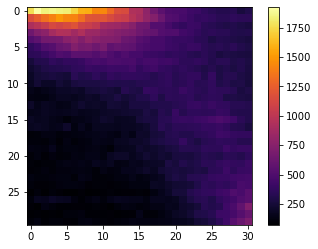

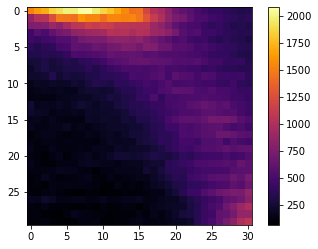

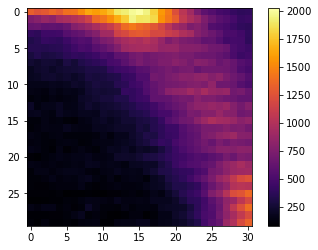

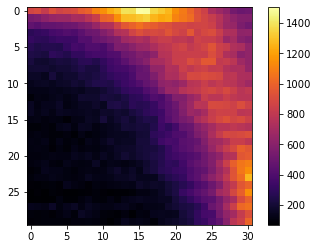

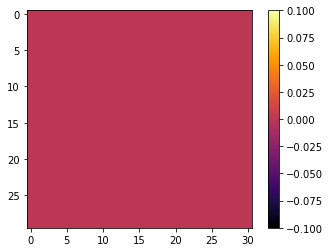

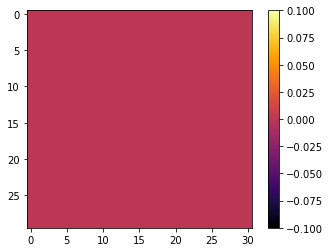

IndexError: index 24 is out of bounds for axis 4 with size 24

In [71]:
for i in range(scans.shape[1]):
    plt.imshow(scans[0,:,:,:,i].sum(axis=0))
    plt.colorbar()
    plt.show()

In [47]:
np.max(scans)

13.0

-3.838782320907831


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


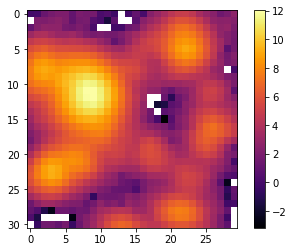

17.903849263093917


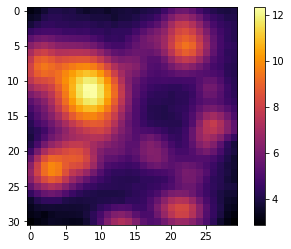

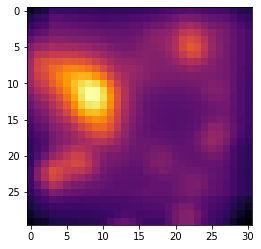

In [57]:
plt.imshow(np.log(xc2.T))
plt.colorbar()
print(np.min(xc2))
plt.show()
plt.imshow(np.log(xc20.T))
plt.colorbar()
print(np.min(xc20))
plt.show()
ac1=si.ac1_image(scans,vx,vy)
plt.imshow(np.log(ac1))

In [ ]:
#IMAGE v2 

In [59]:
scans=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],s.shape[3]+1))
scans[0,:,:,:,:-2]=np.concatenate((s[:,:,:,:14],s[:,:,:,15:]),axis=3)

In [60]:
xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1)

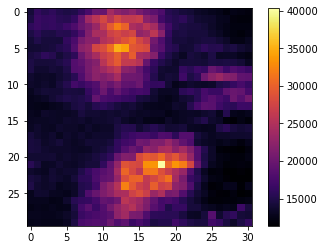

-5.790978940732563


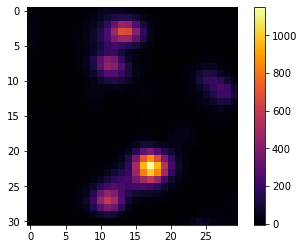

In [63]:
plt.imshow(scans.sum(axis=(0,1,4)))
plt.colorbar()
plt.show()
plt.imshow(xc2.T)
plt.colorbar()
print(np.min(xc2))

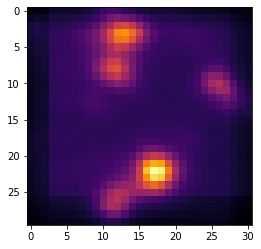

In [62]:
ac1=si.ac1_image(scans,vx,vy)
plt.imshow(ac1)

In [ ]:
#IMAGE v3

In [72]:
scans=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],s.shape[3]+1))
scans[0,:,:,:,:-2]=np.concatenate((s[:,:,:,:14],s[:,:,:,15:]),axis=3)

In [73]:
xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1)
xc20=si.get_xc2(scans[0,:,:,:,:],vx,vy,0)

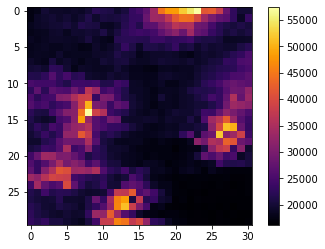

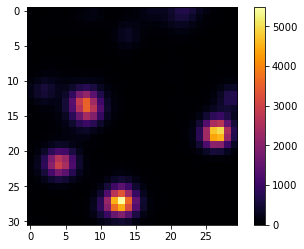

-5.402202824105735


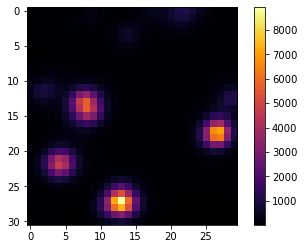

In [82]:
plt.imshow(scans.sum(axis=(0,1,4)))
plt.colorbar()
plt.show()
plt.imshow(xc2.T)
plt.colorbar()
plt.show()
plt.imshow((xc20.T))
plt.colorbar()
print(np.min(xc2))

In [1]:
ac1=si.ac1_image(scans,vx,vy)
plt.imshow(ac1)
scans.sum(axis=(0,1)).shape()
plt.imshow()

NameError: name 'si' is not defined

In [ ]:
for i in range(23);
plt.imshow()

In [45]:

start=time.time()

xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1).T
print(time.time()-start)
#for i in range(3):
#    print(i)
#    xc2+=si.get_xc2(scans[0,:,:,:,:],vx,vy,2+i).T

23.450999975204468


-0.19195693399553265


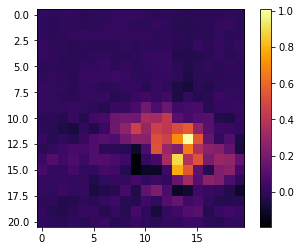

In [43]:
plt.imshow(xc2)
plt.colorbar()
print(np.min(xc2))

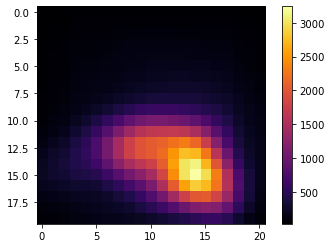

In [33]:
plt.imshow(si.ac1_image(scans,vx,vy))
plt.colorbar()